# BOOK RECOMMENDATION SYSTEM
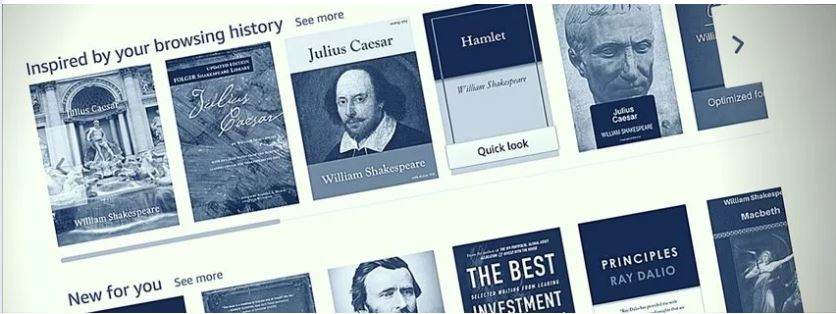

# Introduction
Both the online entertainment and e-commerce companies are trying to retain their customers by taking their access to the website to more personalized manner. So, provide additional recommendations based on users past activity. Our project would be one of such system that recommends additional books that belongs to similar bookauthor or publisher. Such systems result in increase in rate of purchase, these may also include unplanned purchases driven by surprise factor from the recommendations made.

Thus, our business objective is to generate related recommendations(most related books recommendation) for users logged into bookcrossings website.

# Dataset Source
Book crossing is a website that enables free sharing of books, either with friends or with complete strangers by wild-releasing books in public places. 

There are three datasets:

   The BX-Users.csv contains information about 278,858 users ,
   the BX-Books.csv contains information about 271,360 books and finally
   the BX-Book-Rating contains information about 1,149,780 ratings, from 105,283 users and 340,556 items.

The ratings dataset contains explicit feedbacks where users explicitly rate books on a scale of 1-10. We assume that this ratings data is a proxy of the actual preference of the user.

# Problem Statement:

To build a recommendation system to suggest similar books to the user depending on the rating  that the user has provided in the past.

# Reading and Understanding the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore') # Turn off warnings
plt.style.use('seaborn-white') # Use seaborn-style plots
plt.rcParams.update({'font.size': 15}) # Set larger default plot font size
%matplotlib inline
import warnings # supress warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
# The dataset is comprised of three separate tables: BX-Users, BX-Books, and BX-Book-Ratings.
# Each is separated by semi-colons, and the first row contains the column headers.
# Load the data 
Books_df = pd.read_csv('../input/book-recommendation-dataset/Books.csv')
Ratings_df = pd.read_csv('../input/book-recommendation-dataset/Ratings.csv')
Users_df = pd.read_csv('../input/book-recommendation-dataset/Users.csv')

In [4]:
book_ratings=Ratings_df.rename(columns = {'User-ID':'userid', 'ISBN':'isbn', 'Book-Rating':'bookrating'},inplace = False)
users=Users_df.rename(columns={'User-ID':'userid', 'Location':'location', 'Age':'age'},inplace = False)
books=Books_df.rename(columns = {'ISBN':'isbn', 'Book-Title':'booktitle', 'Book-Author':'bookauthor', 'Year-Of-Publication':'yearofpublication', 'Publisher':'publisher', 'Image-URL-S':'image_url_s', 'Image-URL-M':'image_url_m', 'Image-URL-L':'image_url_l'}, inplace = False)


# DATA PREPROCESSING

# Investigate the 'books' dataframe

In [5]:
books.head(4)

,isbn,booktitle,bookauthor,yearofpublication,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...


In [6]:
def dataoveriew(books, message):
    print(f'{message}:\n')
    print("Rows:", books.shape[0])
    print("\nNumber of features:", books.shape[1])
    print("\nFeatures:")
    print(books.columns.tolist())
    print("\n Housing infrmation:")
    print(books.info())
    print("\nMissing values:", books.isnull().sum().values.sum())
    print("\nUnique values:")
    print(books.nunique())

dataoveriew(books, 'Overiew of the  books dataset')    

Overiew of the  books dataset:

Rows: 271360

Number of features: 8

Features:
['isbn', 'booktitle', 'bookauthor', 'yearofpublication', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l']

 Housing infrmation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   isbn               271360 non-null  object
 1   booktitle          271360 non-null  object
 2   bookauthor         271359 non-null  object
 3   yearofpublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   image_url_s        271360 non-null  object
 6   image_url_m        271360 non-null  object
 7   image_url_l        271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None

Missing values: 6

Unique values:
isbn                 271360
booktitle            242135
bookauthor           102023
yearofpublication       202
p

 Let's tidy up the column names. And we can probably drop the image-url link columns

In [7]:
books.columns = books.columns.str.strip().str.lower().str.replace('-', '_') # clean column names
books.drop(columns=['image_url_s', 'image_url_m', 'image_url_l'],axis=1,inplace=True) # drop image-url columns
books.head()

,isbn,booktitle,bookauthor,yearofpublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Year of Publication to be ints or floats, and the rest to be strings ('object'). Espcially  The ISBN numbers may contain some letters, so we CAN'T convert them to numeric values. Will leave as strings.

In [8]:
# Convert years to float
books.yearofpublication = pd.to_numeric(books.yearofpublication, errors='coerce')

In [9]:
# Check for 0's or NaNs in Year of Publication
zero_yr = books[books.yearofpublication == 0].yearofpublication.count()
nan_yr = books.yearofpublication.isnull().sum()
print(f'There are {zero_yr} entries as \'0\', and {nan_yr } NaN entries in the Year of Publication field')

There are 4618 entries as '0', and 3 NaN entries in the Year of Publication field


In [10]:
# Replace all years of zero with NaN
books.yearofpublication.replace(0, np.nan, inplace=True)

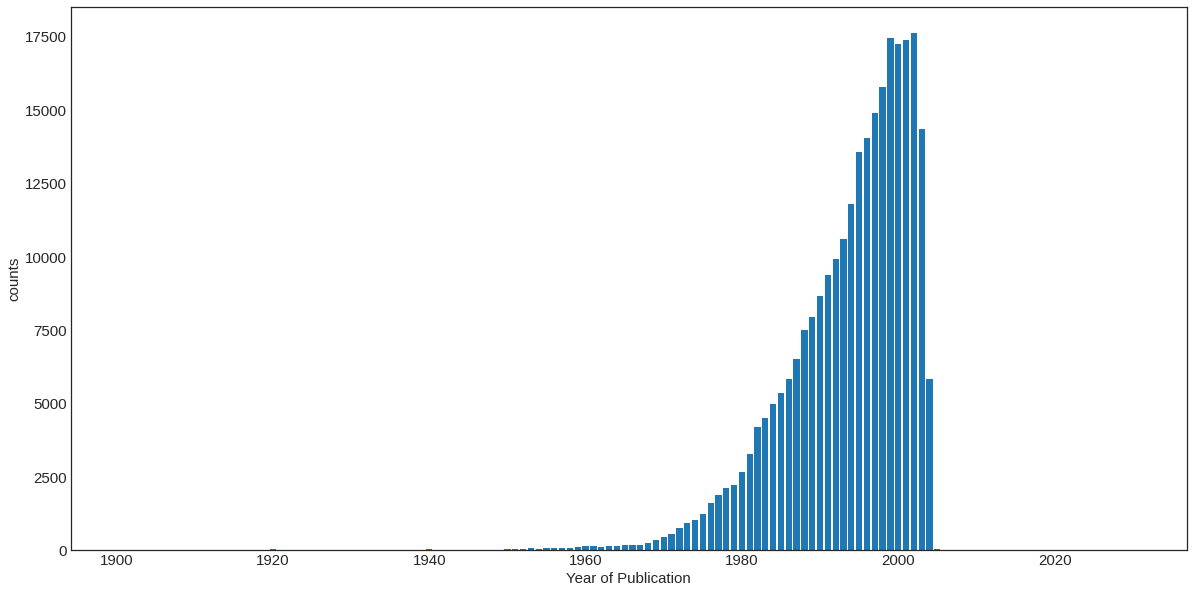

In [11]:
yr = books.yearofpublication.value_counts().sort_index()
yr = yr.where(yr>5) # filter out counts less than 5
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(yr.index, yr.values)
plt.xlabel('Year of Publication')
plt.ylabel('counts')
plt.show()

In [12]:
historical_books = books[books.yearofpublication<1900] # create df of old books
books_from_the_future = books[books.yearofpublication>2018] # create df of books with publication yrs in the future!

hist_books_mini = historical_books[['booktitle', 'yearofpublication']]
future_books_mini = books_from_the_future[['booktitle', 'yearofpublication']]
print(f'Historical books:\n{hist_books_mini}')
print('\n')
print(f'Future books:\n{future_books_mini}')

Historical books:
                                                booktitle  yearofpublication
171817  Complete Works 10 Volumes [2,6,7,8,9] (Notable...             1806.0
227531                   Dalan-i bihisht (Dastan-i Irani)             1378.0
245607  Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...             1897.0
253750                                       Tasht-i khun             1376.0


Future books:
                                                booktitle  yearofpublication
30010                                          The Royals             2020.0
37487   MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...             2030.0
55676   MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...             2030.0
78168                                    Crossing America             2030.0
80264   Alice's Adventures in Wonderland and Through t...             2050.0
92156                     Edgar Allen Poe Collected Poems             2020.0
97826       Outline of European Architectu

we can probably omit the 'historical_books' as they may potentially skew the model and do not seem to have much relevance to the wider userbase.
Some of the 'future' books actually appear to be errors (e.g. Alice in Wonderland, Edgar Allen Poe, etc.). Perhaps they were supposed to be e.g. 1950 instead of 2050? However, instead of investigating this further, 
since there are <20 books here I will simply remove them from the 'books' table.

In [13]:
print(f'Length of books dataset before removal: {len(books)}')
books = books.loc[~(books.isbn.isin(historical_books.isbn))] # remove historical books
books = books.loc[~(books.isbn.isin(books_from_the_future.isbn))] # remove historical books
print(f'Length of books dataset after removal: {len(books)}')

Length of books dataset before removal: 271360
Length of books dataset after removal: 271339


In [14]:
books.publisher = books.publisher.str.replace('&amp', '&', regex=False)
books.head(3)

,isbn,booktitle,bookauthor,yearofpublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial


In [15]:
uniq_books = books.isbn.nunique()
all_books = books.isbn.count()
print(f'No. of unique books: {uniq_books} | All book entries: {all_books}')

No. of unique books: 271339 | All book entries: 271339


check no duplicate entries

In [16]:
top_publishers = books.publisher.value_counts()[:10]
print(f'The 10 publishers with the most entries in the books table are:\n{top_publishers}')

The 10 publishers with the most entries in the books table are:
Harlequin                   7535
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3646
Scholastic                  3159
Simon &; Schuster           2969
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Name: publisher, dtype: int64


In [17]:
top_authors = books.bookauthor.value_counts()[:10]
print(f'The 10 authors with the most entries in the books table are:\n{top_authors}')

The 10 authors with the most entries in the books table are:
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: bookauthor, dtype: int64


In [18]:
empty_string_publisher = books[books.publisher == ''].publisher.count()
nan_publisher = books.publisher.isnull().sum()
print(f'There are {empty_string_publisher} entries with empty strings, and {nan_publisher} NaN entries in the Publisher field')

There are 0 entries with empty strings, and 2 NaN entries in the Publisher field


In [19]:
empty_string_author = books[books.bookauthor == ''].bookauthor.count()
nan_author = books.bookauthor.isnull().sum()
print(f'There are {empty_string_author} entries with empty strings, and {nan_author} NaN entries in the Author field')

There are 0 entries with empty strings, and 1 NaN entries in the Author field


In [20]:
top_titles = books.booktitle.value_counts()[:10]
print(f'The 10 book titles with the most entries in the books table are:\n{top_titles}')

The 10 book titles with the most entries in the books table are:
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
Adventures of Huckleberry Finn    20
Dracula                           20
The Secret Garden                 20
Jane Eyre                         19
The Night Before Christmas        18
Pride and Prejudice               18
Great Expectations                17
Name: booktitle, dtype: int64


Although  ISBN entries are unique in the 'books' dataframe, different forms of the same book will have different ISBNs - i.e. paperback, e-book, etc. Therefore, we can see that some books have multiple ISBN entries 
(e.g. Jane Eyre has 19 different ISBNs,each corresponding to a different version of the book).

In [21]:
books[books.booktitle=='Jane Eyre'].head()

,isbn,booktitle,bookauthor,yearofpublication,publisher
3323,0451518845,Jane Eyre,Charlotte Bronte,1999.0,New Amer Library Classics
9545,0451523326,Jane Eyre,Charlotte Bronte,1988.0,Signet Classics
27657,1566193028,Jane Eyre,Charlotte Bronte,1994.0,Dorset Press
28501,156619024X,Jane Eyre,Charlotte Bronte,NaN,Barnes Noble Classics
40050,8426102069,Jane Eyre,Charlotte Bronte,1997.0,Juventud


In [22]:
users.head(2)

,userid,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [23]:
def dataoveriew(users, message):
    print(f'{message}:\n')
    print("Rows:", users.shape[0])
    print("\nNumber of features:", users.shape[1])
    print("\nFeatures:")
    print(users.columns.tolist())
    print("\n Housing infrmation:")
    print(users.info())
    print("\nMissing values:", users.isnull().sum().values.sum())
    print("\nUnique values:")
    print(users.nunique())
    print(f'Users: {len(users)}\nBooks: {len(books)}\nRatings: {len(book_ratings)}')
dataoveriew(users, 'Overiew of the  users dataset')    

Overiew of the  users dataset:

Rows: 278858

Number of features: 3

Features:
['userid', 'location', 'age']

 Housing infrmation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userid    278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None

Missing values: 110762

Unique values:
userid      278858
location     57339
age            165
dtype: int64
Users: 278858
Books: 271339
Ratings: 1149780


No. of unique user_id entries: 278858 | Total user_id entries: 278858
The 'User-ID' field is integers, 'Location' are strings', and the 'Age' values are floats.

We can probably change the ages to ints. Let's take a look at the values first

In [24]:
users.columns = users.columns.str.strip().str.lower().str.replace('-', '_')
users.head(2)

,userid,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


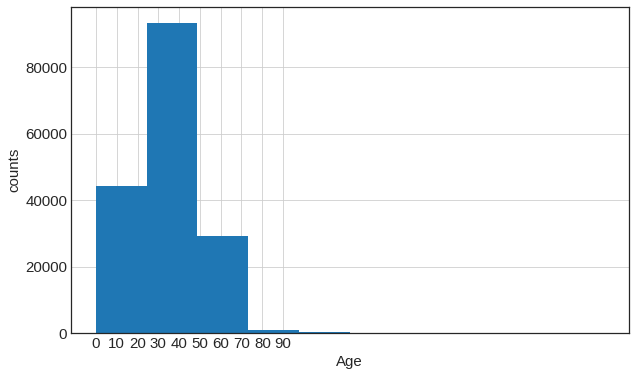

In [25]:
# First create a histogram of the Age field
ax = users.age.hist(bins=10, figsize=(10,6))
ax.set_xlabel('Age')
ax.set_ylabel('counts')
ax.set_xticks(range(0,100,10))
plt.show()

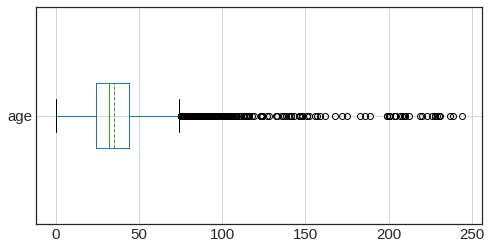

In [26]:
ax_age =users.boxplot('age', vert=False, figsize=(8, 4), 
                            widths=0.3, showmeans=True, meanline=True)

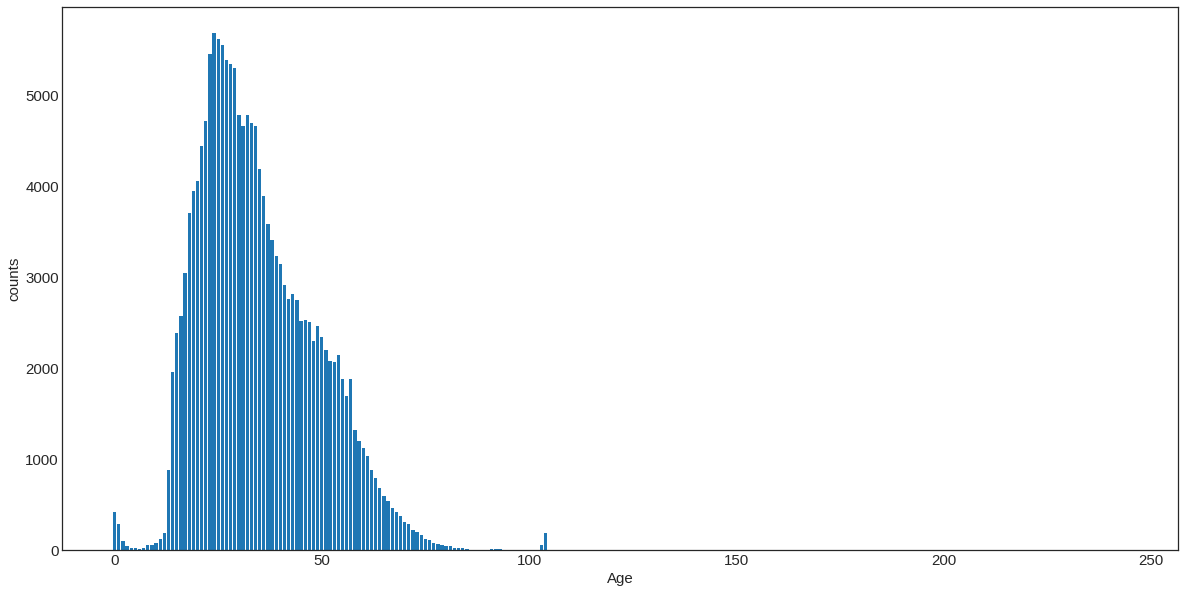

In [27]:
u = users.age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

That is more clear to me! It seems that most of our reviewers are in their late 20s to early 30s

In [28]:
age_null = users.age.isnull().sum() # Sums up the 1's returned by the isnull() mask
all_users = users.userid.count() # Counts the number of cells in the series - excludes NaNs!
print(f'There are {age_null} empty age values in our set of {all_users} users (or {(age_null/all_users)*100:.2f}%).')

There are 110762 empty age values in our set of 278858 users (or 39.72%).


In [29]:
users.head(2)

,userid,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [30]:
# Note: Used Pandas Series.str.split method as it has an 'expand' parameter which can handle None cases
user_location_expanded = users.location.str.split(',', 2, expand=True)
user_location_expanded.columns = ['city', 'state', 'country']
users = users.join(user_location_expanded)

In [31]:
users.drop(columns=['location'],axis=1, inplace=True)
users.head(2)

,userid,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa


In [32]:
#Top cities using users
top_cities = users.city.value_counts()[:10]
print(f'The 10 cities with the most users are:\n{top_cities}')

The 10 cities with the most users are:
london       4105
barcelona    2664
toronto      2342
madrid       1933
sydney       1884
portland     1869
melbourne    1863
vancouver    1699
chicago      1566
seattle      1541
Name: city, dtype: int64


In [33]:
top_countries = users.country.value_counts()[:10]
print(f'The 10 countries with the most users are:\n{top_countries}')

The 10 countries with the most users are:
 usa               139183
 canada             21556
 united kingdom     18286
 germany            17021
 spain              13088
 australia          11719
 italy              11238
                     4561
 france              3440
 portugal            3305
Name: country, dtype: int64


It shows  like an empty 'Country' field is in the top 10 most common entries!

In [34]:
empty_string_country = users[users.country == ''].country.count()
nan_country = users.country.isnull().sum()
print(f'There are {empty_string_country} entries with empty strings, and {nan_country} NaN entries in the Country field')

There are 4561 entries with empty strings, and 2 NaN entries in the Country field


In [35]:
users.country.replace('', np.nan, inplace=True)

In [36]:
book_ratings.head(2)

,userid,isbn,bookrating
0,276725,034545104X,0
1,276726,0155061224,5


In [37]:
def dataoveriew(book_ratings, message):
    print(f'{message}:\n')
    print("Rows:", book_ratings.shape[0])
    print("\nNumber of features:", book_ratings.shape[1])
    print("\nFeatures:")
    print(book_ratings.columns.tolist())
    print("\n Housing infrmation:")
    print(book_ratings.info())
    print("\nMissing values:", book_ratings.isnull().sum().values.sum())
    print("\nUnique values:")
    print(book_ratings.nunique())

dataoveriew(book_ratings, 'Overiew of the  book_ratings dataset')    

Overiew of the  book_ratings dataset:

Rows: 1149780

Number of features: 3

Features:
['userid', 'isbn', 'bookrating']

 Housing infrmation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userid      1149780 non-null  int64 
 1   isbn        1149780 non-null  object
 2   bookrating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None

Missing values: 0

Unique values:
userid        105283
isbn          340556
bookrating        11
dtype: int64


Data types already look good

In [38]:
super_users = book_ratings.groupby('userid').isbn.count().sort_values(ascending=False)
print(f'The 20 users with the most ratings:\n{super_users[:20]}')

The 20 users with the most ratings:
userid
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
230522     2991
16795      2948
234623     2674
36836      2529
52584      2512
245963     2507
204864     2504
55492      2459
185233     2448
171118     2421
Name: isbn, dtype: int64


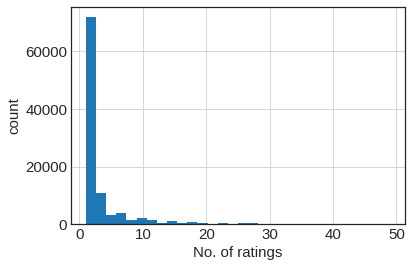

In [39]:
# user distribution - users with more than 50 ratings removed
user_hist = super_users.where(super_users<50)
user_hist.hist(bins=30)
plt.xlabel('No. of ratings')
plt.ylabel('count')
plt.show()

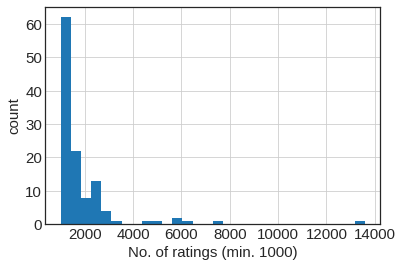

In [40]:
#only users with more than 1000 ratings
super_user_hist = super_users.where(super_users>1000)
super_user_hist.hist(bins=30)
plt.xlabel('No. of ratings (min. 1000)')
plt.ylabel('count')
plt.show()

In [41]:
ratings =book_ratings.dropna()
print(ratings.shape)

(1149780, 3)


Text(0.5, 1.0, 'Rating Distribution')

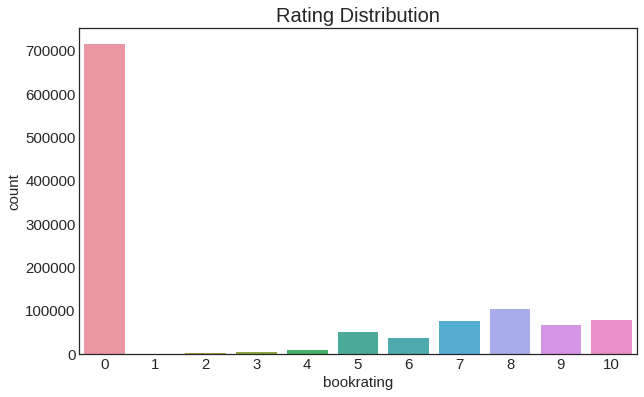

In [42]:
plt.figure(figsize=(10,6))
sns.countplot(x='bookrating',data=book_ratings)
plt.title('Rating Distribution',size=20)

In [43]:
ratings = ratings[ratings['bookrating'] != 0]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433671 entries, 1 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userid      433671 non-null  int64 
 1   isbn        433671 non-null  object
 2   bookrating  433671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB


In [44]:
ratings.shape

(433671, 3)

In [45]:
ratings.head(5)

,userid,isbn,bookrating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


Text(0.5, 1.0, 'Rating Distribution')

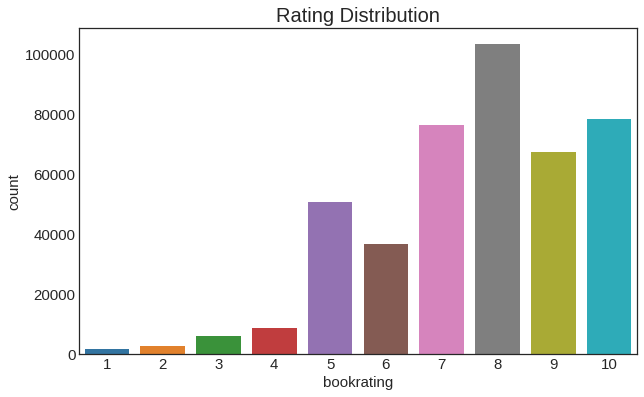

In [46]:
plt.figure(figsize=(10,6))
sns.countplot(x='bookrating',data=ratings)
plt.title('Rating Distribution',size=20)

In [47]:
print(f'Books table size: {len(books)}')
print(f'Ratings table size: {len(book_ratings)}')
books_with_ratings = ratings.join(books.set_index('isbn'), on='isbn')
print(f'New table size: {len(books_with_ratings)}')

Books table size: 271339
Ratings table size: 1149780
New table size: 433671


In [48]:
books_with_ratings.head()

,userid,isbn,bookrating,booktitle,bookauthor,yearofpublication,publisher
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press
6,276736,3257224281,8,NaN,NaN,NaN,NaN
7,276737,0600570967,6,NaN,NaN,NaN,NaN


In [49]:
print(f'There are {books_with_ratings.booktitle.isnull().sum()} books with no title/author information.')
print(f'This represents {len(books_with_ratings)/books_with_ratings.booktitle.isnull().sum():.2f}% of the ratings dataset.')

There are 49861 books with no title/author information.
This represents 8.70% of the ratings dataset.


In [50]:
books_with_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433671 entries, 1 to 1149779
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   userid             433671 non-null  int64  
 1   isbn               433671 non-null  object 
 2   bookrating         433671 non-null  int64  
 3   booktitle          383810 non-null  object 
 4   bookauthor         383809 non-null  object 
 5   yearofpublication  378026 non-null  float64
 6   publisher          383808 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 42.6+ MB


Year of publication field contains the most NaN entries, while user_id, isbn, and book_rating are full. The book_title, book_author, and publisher fields contain approximately the same number of missing entries.

In [51]:
books_with_ratings.dropna(subset=['booktitle'], inplace=True) # remove rows with missing title/author data


In [52]:
print(f'Books+Ratings table size: {len(books_with_ratings)}')
print(f'Users table size: {len(users)}')
books_users_ratings = books_with_ratings.join(users.set_index('userid'), on='userid')
print(f'New "books_users_ratings" table size: {len(books_users_ratings)}')

Books+Ratings table size: 383810
Users table size: 278858
New "books_users_ratings" table size: 383810


In [53]:
books_users_ratings.head(3)

,userid,isbn,bookrating,booktitle,bookauthor,yearofpublication,publisher,age,city,state,country
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,NaN,seattle,washington,usa
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,16.0,rijeka,n/a,croatia
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,16.0,rijeka,n/a,croatia


Some missing age, yearofpublication, publisher, and country entries, but the primary fields of user_id,  book_rating are all full, which is good.

In [54]:
books_users_ratings.shape

(383810, 11)

# DATA VISUALIZATION

Text(0.5, 0, 'Number of books')

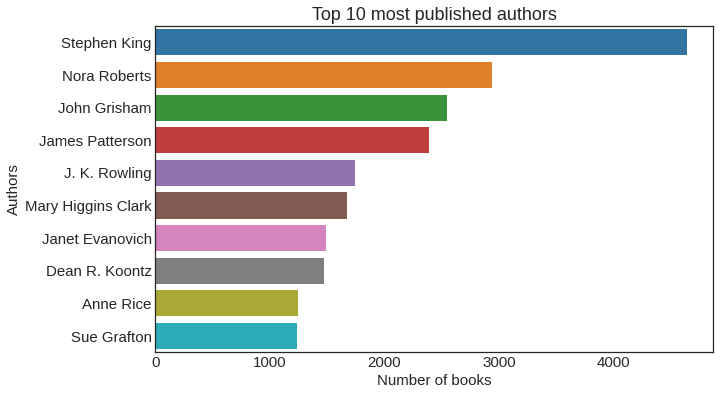

In [55]:
most_authors = (books_users_ratings[books_users_ratings["bookauthor"] != "Not Applicable (Na )"])["bookauthor"].value_counts()[:10]
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Top 10 most published authors")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(y= most_authors.index, x=most_authors.values)

# Add label for vertical axis
plt.ylabel("Authors")
plt.xlabel("Number of books")

Text(0.5, 0, 'Number of books')

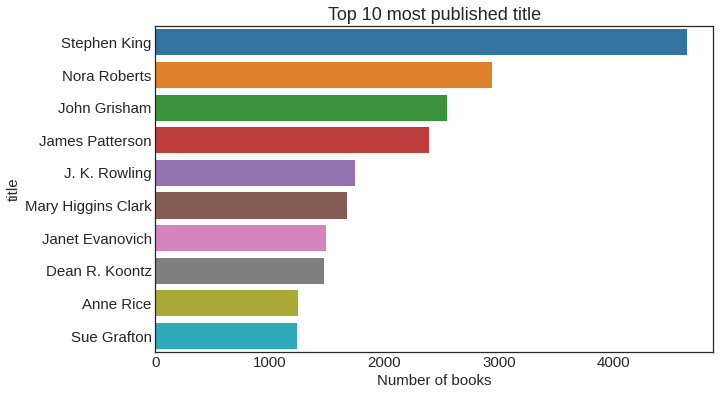

In [56]:
most_title = (books_users_ratings[books_users_ratings["booktitle"] != "Not Applicable (Na )"])["booktitle"].value_counts()[:10]
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Top 10 most published title")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(y= most_authors.index, x=most_authors.values)

# Add label for vertical axis
plt.ylabel("title")
plt.xlabel("Number of books")

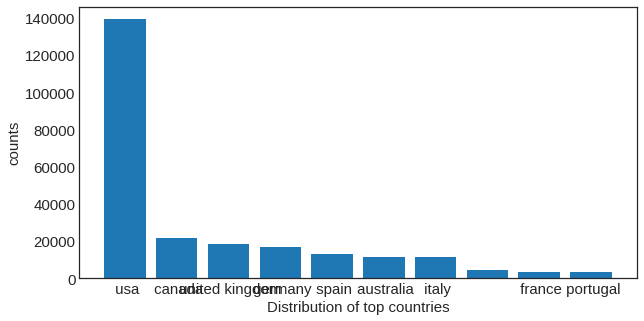

In [57]:
#Top 10 countries
plt.figure(figsize=(10, 5))
plt.bar(top_countries.index, top_countries.values)
plt.xlabel('Distribution of top countries')
plt.ylabel('counts')
plt.show()

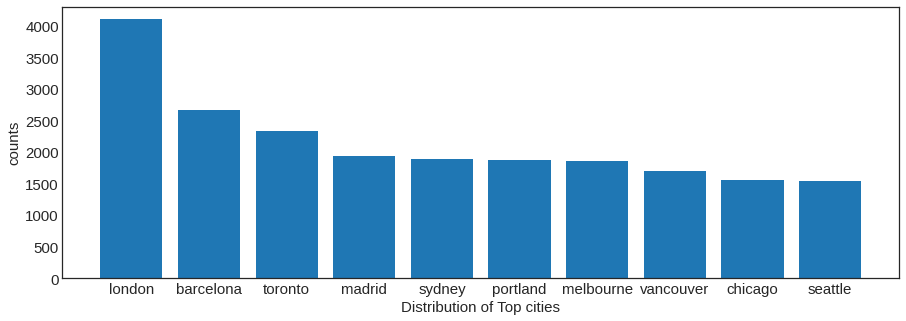

In [58]:
#Top 10 cities
plt.figure(figsize=(15, 5))
plt.bar(top_cities.index, top_cities.values)
plt.xlabel('Distribution of Top cities')
plt.ylabel('counts')
plt.show()

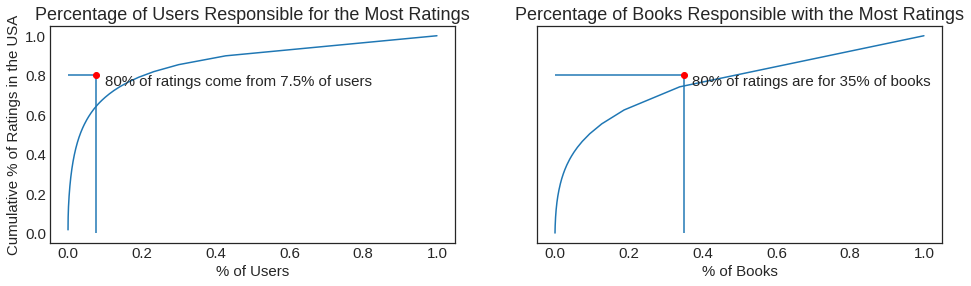

In [59]:
#differntiate of user and book
user_y = (books_users_ratings['userid'].value_counts().cumsum()/len(books_users_ratings)).values
user_x = np.arange(1,len(user_y)+1) / len(user_y)

fig,[ax0,ax1] = plt.subplots(1,2,figsize=(16,4),sharey=True);
ax0.plot(user_x,user_y);
ax0.set_ylabel('Cumulative % of Ratings in the USA');
ax0.set_xlabel('% of Users');
ax0.set_title('Percentage of Users Responsible for the Most Ratings');
ax0.vlines(.075,0,0.8);
ax0.hlines(.8,0,.075);
ax0.plot(.075,.8,marker='o',color='red');
ax0.annotate(xy=(.1,.75),s='80% of ratings come from 7.5% of users');

book_y = (books_users_ratings['isbn'].value_counts().cumsum()/len(books_users_ratings)).values
book_x = np.arange(1,len(book_y)+1) / len(book_y)

ax1.plot(book_x,book_y);
ax1.set_xlabel('% of Books');
ax1.set_title('Percentage of Books Responsible with the Most Ratings');
xper = .35
ax1.vlines(xper,0,0.8);
ax1.hlines(.8,0,xper);
ax1.plot(xper,.8,marker='o',color='red');
ax1.annotate(xy=(xper+.02,.75),s='80% of ratings are for 35% of books');



It looks like most ratings come from a very small % of users while about 80% of ratings ome from 35% of books. When the books get to 85% of ratings, the exponential trend turns into a linear trend.

# ANALYSIS BY BOOK-DATA

In [60]:
RatingCount = pd.DataFrame(ratings.groupby('isbn')['bookrating'].count())
RatingCount.sort_values('bookrating',ascending = False).head()
most_rated_books=pd.DataFrame(['0971880107','0316666343','0385504209','0060928336','0312195516'],
                              index=np.arange(5),columns=['isbn'])
display('Top 5 Books with Most Ratings', 
        pd.merge(most_rated_books,books,on='isbn'))

'Top 5 Books with Most Ratings'

,isbn,booktitle,bookauthor,yearofpublication,publisher
0,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
2,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA


In [61]:
top_ten_books= pd.DataFrame(books_users_ratings.groupby('booktitle')['bookrating'].count()
                         .sort_values(ascending=False).head(10))

print('The top ten books recommendation : ')
top_ten_books

The top ten books recommendation : 


,bookrating
booktitle,
The Lovely Bones: A Novel,707
Wild Animus,581
The Da Vinci Code,494
The Secret Life of Bees,406
The Nanny Diaries: A Novel,393
The Red Tent (Bestselling Backlist),383
Bridget Jones's Diary,377
A Painted House,366
Life of Pi,336


# Wordclouds(Text Preprocessing)
 

A simple model where we count the occurrences of words in each document and then compare those numbers between different documents and analyze,which books have similar words in them.

In [62]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [63]:
import re
books_users_ratings['booktitle'] = books_users_ratings['booktitle'].apply(lambda x:clean_text(x))

<AxesSubplot:title={'center':'Word Count Distribution for book title'}, ylabel='Frequency'>

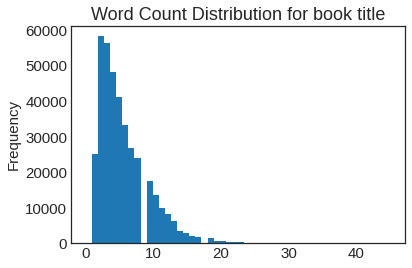

In [64]:
#Calculating the word count for book-title
books_users_ratings['word_count'] = books_users_ratings['booktitle'].apply(lambda x: len(str(x).split()))# Plotting the word count
books_users_ratings['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (6,4),title='Word Count Distribution for book title')

In [65]:
from wordcloud import WordCloud,STOPWORDS
stop_words=set(STOPWORDS)
booktitle_string = " ".join(books_users_ratings['booktitle'])

In [66]:
def wordcloud(string):
    wc = WordCloud(width=800,height=500,mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(string)
    fig=plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(wc)

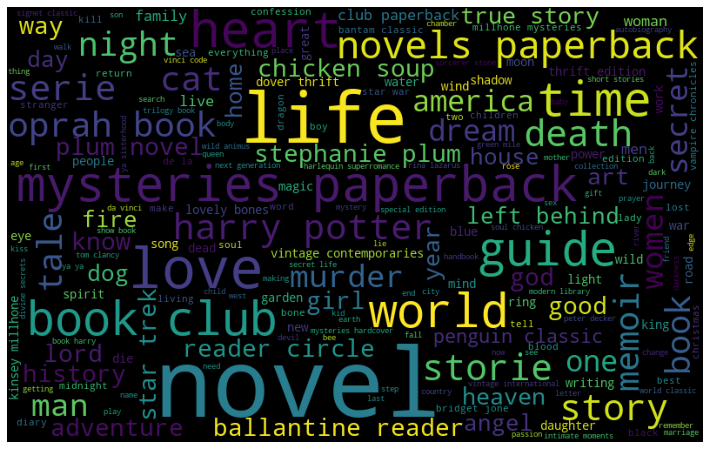

In [67]:
wordcloud(booktitle_string)

# Popularity Based Recommendation

In [68]:
most_rated=books.loc[books.isbn.isin(list(avg_and_count.head()['isbn']))]
most_rated

NameError: name 'avg_and_count' is not defined

In [ ]:
rating_count=pd.DataFrame(ratings.groupby('isbn',as_index=False)['bookrating'].count())
avg_rating=pd.DataFrame(ratings.groupby('isbn',as_index=False)['bookrating'].mean())
avg_and_count=avg_rating.merge(rating_count, on='isbn',how="inner")
avg_and_count.columns=["iSBN","avg_rating","ratings_count"]
avg_and_count=avg_and_count.sort_values('ratings_count',ascending=False)
avg_and_count.head()

Popularity Based Recommendation is one of the best rcommendation model usage 

# Building a Content-Based Book Recommendation Model

Content Based recommendation builds a system that recommends books that are similar to a particular book. More specifically, we compute pairwise similarity scores for all books based on their BookTitle, BookAuthor, and Publisher and also recommend books based on that similarity score.
This should help discover similar books based on the same author, publisher, and book title. This model is computed naively, as all the BookTitle, BookAuthor, and Publisher are weighted equally based on the raw counts of trigrams.

In [ ]:
#Content based Recommender
#Print plot overviews of the first 5 booktitle.
books_users_ratings['booktitle'].head(5)

In [ ]:
#Print the top 10 books
books_users_ratings[['booktitle','bookauthor','publisher','bookrating']].head(3)

This method is using by book title, authors or rating, so that new book can be recommended right away.

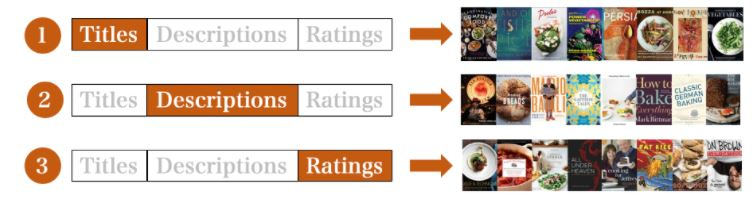

In [ ]:
newbook_data =books_users_ratings [['booktitle','bookauthor','bookrating']]
newbook_data = newbook_data.astype(str)
newbook_data['content'] = newbook_data['booktitle'] + ' ' + newbook_data['bookauthor'] + ' ' + newbook_data['bookrating']
newbook_data = newbook_data.reset_index()


In [ ]:
indices = pd.Series(newbook_data.index, index=newbook_data['booktitle'])

In [ ]:
#Do some NLP to extract important words using TF-IDF 
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(newbook_data['bookauthor'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

In [ ]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books_users_ratings['booktitle'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )


In [ ]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[5000:5010]

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim_author = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
def get_recommendations_books(title, cosine_sim=cosine_sim_author):
    idx = indices[title]

    # Get the pairwsie similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim_author[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:10]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar books
    return list(content_data['booktitle'].iloc[book_indices])

It looks like this content-based recommender system is able to capture similarity within books based on the rating I have used, giving interesting and relevant recommendations.

In [ ]:
def author_book_shows(book):
    for book in book:
        print(book)

In [ ]:
books1 =get_recommendations_books('The Catcher in the Rye', cosine_sim_author)
author_book_shows(books1)

In [ ]:
books2 =get_recommendations_books('The Great Gatsby', cosine_sim_author)
author_book_shows(books2)

Recommendation based on book title


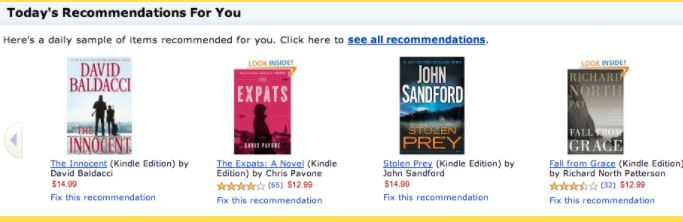

# Conclusions

As seen from the above experiment we can notice that content recommender generates the more diverse set of results compared to other algorithms. The popular based recommendations are better compared to content based recommendations. This is because of the sparsity of the data for the content based recommendation.

# REFERRENCES
1.https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html

2.https://towardsdatascience.com/building-a-recommendation-system-for-fragrance-5b00de3829da

# THANK YOU